In [3]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers

     |████████████████████████████████| 2.8 MB 8.8 MB/s 
     |████████████████████████████████| 50 kB 5.2 MB/s 
     |████████████████████████████████| 636 kB 52.3 MB/s 
     |████████████████████████████████| 895 kB 43.4 MB/s 
     |████████████████████████████████| 3.3 MB 56.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 8.5 MB/s 


In [4]:
from google.colab import files
from abc import ABC, abstractmethod
from typing import List 
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import BertTokenizer, BertModel
from torch import nn, utils
from torch.utils.data import TensorDataset, RandomSampler, Dataset
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
#upload kaggle.json file with permission ro download jigsaw-toxic-comment-classification-challenge dataset
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 102MB/s]
 21% 5.00M/23.4M [00:00<00:00, 21.3MB/s]
100% 23.4M/23.4M [00:00<00:00, 65.4MB/s]
 19% 5.00M/26.3M [00:00<00:00, 31.3MB/s]
100% 26.3M/26.3M [00:00<00:00, 103MB/s] 
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 200MB/s]


In [7]:
! ls  

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip
sample_data  test.csv.zip		train.csv.zip


In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!ls

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip  train.csv.zip
sample_data  test.csv.zip		train.csv


In [10]:
SAMPLE_SIZE = 100000

In [11]:
df = pd.read_csv("train.csv")[['id', 'comment_text', 'toxic']].sample(SAMPLE_SIZE)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3915 to 33224
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  object
 1   comment_text  100000 non-null  object
 2   toxic         100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB


In [13]:
df.sample(3)

,id,comment_text,toxic
88435,ec926152b857a62f,Joanne offers both Ali and Alf a full breakfas...,0
60283,a15db94a78c623f8,There is so much else to be getting on with ra...,0
109315,48a2bc0e7a2b5f5c,Proof by Sabotage of the opposing viewpoint \n...,0


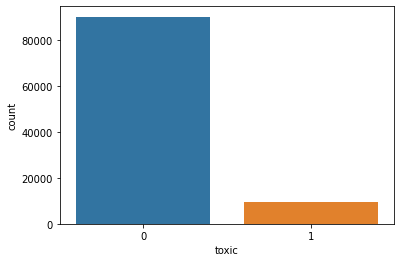

In [14]:
ax = sns.countplot(x="toxic", data=df)

In [15]:
df.rename(columns={'toxic': 'target'}, inplace = True)

train_df, validation_df = train_test_split(df, test_size = 0.2)
train_df.shape[0], validation_df.shape[0]

(80000, 20000)

In [16]:
bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True).to(device)

bert.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
CLS = "{} ".format(tokenizer.cls_token)
SEP = " {}".format(tokenizer.sep_token)
MAX_NUMBER_OF_WORDS_IN_SENTENSE = 512
SEP, CLS

(' [SEP]', '[CLS] ')

In [18]:
class BaseClassifier(ABC):
  
  def __init__(self, bert_model, tokenizer):
    self._bert_model = bert_model
    self._bert_model.eval()
    self._tokenizer = tokenizer

  @abstractmethod
  def fit(self, df: pd.DataFrame):
    pass 

  @abstractmethod
  def predict(self, df: pd.DataFrame):
    pass 
  
  def text_to_tokens_ids(self, text):

    marked_text = CLS + text + SEP
    tokenized_text = self._tokenizer.tokenize(marked_text)[0: MAX_NUMBER_OF_WORDS_IN_SENTENSE]
    indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)

    return indexed_tokens

  def text_to_sentense_embeddingds(self, text: str, embeddings_layer: int):
    indexed_tokens = self.text_to_tokens_ids(text)
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_ids = [1] * len(indexed_tokens)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    with torch.no_grad():
      outputs = self._bert_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]
      
    return torch.mean(hidden_states[embeddings_layer], dim=1).detach().cpu().numpy().flatten() if embeddings_layer is not None else hidden_states
  
  def evaluate(self, df):
    predictions = self.predict(df)
    targets = df['target'].tolist()

    precision, recall, fscore, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    return pd.DataFrame([(precision, recall, fscore)], columns = ['precision','recall', 'fscore'])

  
class NearestNeiborClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  

class TorchClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)


In [19]:
class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):

        row = self._df.iloc[idx]
        return row['id'], row['comment_text_tokens_ids'], row['target'] if 'target' in self._df.columns else -1

In [20]:
def group_rows(rows):

    max_length = np.max([len(tokenes_ids) for _, tokenes_ids, _ in rows])

    ids = [id for id, _, _ in rows]

    tokenes_ids = torch.LongTensor([np.concatenate([tokenes_ids, np.repeat(tokenizer.pad_token_id, max_length - len(tokenes_ids))])
                   for id, tokenes_ids, target in rows])


    targets = [target for _, _, target in rows]

    masks = torch.LongTensor([np.concatenate([np.repeat(1, len(tokenes_ids)), np.repeat(0, max_length - len(tokenes_ids))])
          for _, tokenes_ids, _ in rows])
    
    return ids, tokenes_ids, masks, torch.FloatTensor(targets).reshape(-1, 1)


In [21]:
class RelevanceModel(nn.Module):

    def __init__(self, bert, embeddings_layer):

        super(RelevanceModel, self).__init__()

        self._embeddings_layer = embeddings_layer
        self._bert = bert

        self._bert.eval()

        for param in self._bert.parameters():
            param.requires_grad = False

        self.af1 = nn.LeakyReLU()
        self.fc1 = nn.Linear(768, 1)

    def forward(self, tokens, attention_mask):
        
        hidden_states = self._bert(tokens, attention_mask)[2]

        sentense_embeddingds = torch.mean(hidden_states[self._embeddings_layer], dim=1)

        out = self.af1(sentense_embeddingds)

        out = self.fc1(out)

        return out

    def reset_parameters(self):
      
        initrange = 0.5
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        return self

In [22]:
class DeepModel(BaseClassifier):

    def __init__(self, bert, tokenizer, embeddings_layer, batch_size,
                 prediction_threshold, learnning_rate = 0.001,
                 number_of_epocs = 1000):
        BaseClassifier.__init__(self, bert, tokenizer)
        bert.to(device)
        self._model  = RelevanceModel(bert, embeddings_layer).reset_parameters()
        self._model.to(device)
        self._batch_size = batch_size
        self._prediction_threshold = prediction_threshold
        self._learnning_rate = learnning_rate
        self._number_of_epocs = number_of_epocs

    def _calc_positive_weight(self, df: pd.DataFrame) -> float:
      weights = compute_class_weight('balanced', np.unique(train_df.target),  train_df.target)
      pos_weight = weights[1]/weights[0]

      return pos_weight   


    def _preprocessing(self, df: pd.DataFrame):
      df['comment_text_tokens_ids'] = df['comment_text'].progress_apply(lambda text: self.text_to_tokens_ids(text))

    def fit(self, df: pd.DataFrame):

        self._model.train()

        positive_weight = self._calc_positive_weight(df)
        pos_weights_tensor = torch.Tensor([positive_weight])
       
        self._preprocessing(df)

        optimizer = torch.optim.Adam(self._model.parameters(), lr=self._learnning_rate)
        train_dataset = DatasetLoader(df)
        sampler = RandomSampler(train_dataset)

        train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                        batch_size=self._batch_size,
                                                        shuffle=False,
                                                        num_workers=4,
                                                        drop_last=False,
                                                        sampler=sampler,
                                                        collate_fn=group_rows)

        loss_fn  = nn.BCEWithLogitsLoss(pos_weight = pos_weights_tensor).to(device)

        for batch in range(self._number_of_epocs):

          total_loss = 0.0
          for ids, tokends_ids, attention_mask, targets in train_data_loader:
                
              tokends_ids = tokends_ids.to(device)
              attention_mask = attention_mask.to(device)
              targets = targets.to(device)

              optimizer.zero_grad()

              output = self._model(tokends_ids, attention_mask)
              loss = loss_fn(output, targets)
    
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
            
          print('batch {} loss {}'.format(batch, total_loss/len(train_dataset)))

    def predict(self, df: pd.DataFrame):

      self._preprocessing(df)
      
      self._model.eval()

      predict_dataset_loader = DatasetLoader(df)

      predict_data_loader = torch.utils.data.DataLoader(predict_dataset_loader,
                                                              batch_size=self._batch_size,
                                                              shuffle=False,
                                                              num_workers=4,
                                                              drop_last=False,
                                                              collate_fn=group_rows)
      with torch.no_grad():

        predictions = {}
        
        for ids, tokends_ids, attention_mask, _ in predict_data_loader:
          tokends_ids = tokends_ids.to(device)
          attention_mask = attention_mask.to(device)
          
          logit = self._model(tokends_ids, attention_mask)

          probs = torch.sigmoid(logit).detach().cpu().numpy().flatten()
          batch_predictions = probs > self._prediction_threshold

          for id, prediction in zip(ids, batch_predictions):
            predictions[id] = prediction 
          
      return df['id'].apply(lambda id: predictions[id]).tolist()
      

In [1]:
# hidden_layer = 12
# deep_model = DeepModel(bert, tokenizer, hidden_layer, BATCH_SIZE, PREDICTION_THRESHOLD)

# deep_model.fit(train_df.sample(1000))
# scores2 = deep_model.evaluate(validation_df.sample(100))
# scores2['model'] = 'deep'
# scores2['hidden_layer'] = 11



In [25]:
BATCH_SIZE = 32
PREDICTION_THRESHOLD = 0.65 
N_NEIGHBORS = 3
NUMBER_OF_EPOCS = 5
EMBEDDING_LAYERS_TO_CHECK = [9,10, 11, 12]
scores_dfs = []

train_df = train_df.sample(2000)
validation_df = validation_df.sample(200)

for hidden_layer in EMBEDDING_LAYERS_TO_CHECK:

  print('running on hidden layer {}'.format(hidden_layer))

  deep_model = DeepModel(bert, tokenizer, hidden_layer, BATCH_SIZE, PREDICTION_THRESHOLD, 
                         number_of_epocs = NUMBER_OF_EPOCS)

  deep_model.fit(train_df)
  scores_df = deep_model.evaluate(validation_df)
  scores_df['model'] = 'Deep'
  scores_df['hidden_layer'] = hidden_layer
  scores_dfs.append(scores_df)
  

  nearestNeiborClassifier = NearestNeiborClassifier(bert, tokenizer, hidden_layer, N_NEIGHBORS)
  nearestNeiborClassifier.fit(train_df)
  scores_df = nearestNeiborClassifier.evaluate(validation_df)

  scores_df['model'] = 'NearestNeibor'
  scores_df['hidden_layer'] = hidden_layer
  scores_dfs.append(scores_df)




running on hidden layer 9


100%|██████████| 2000/2000 [00:03<00:00, 583.10it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch 0 loss 0.044949567258358004
batch 1 loss 0.037968938887119295
batch 2 loss 0.03299155059456825
batch 3 loss 0.030061348855495454
batch 4 loss 0.027999427273869514


100%|██████████| 200/200 [00:02<00:00, 82.95it/s]


running on hidden layer 10


100%|██████████| 2000/2000 [00:03<00:00, 609.56it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch 0 loss 0.04609228113293648
batch 1 loss 0.03749821212887764
batch 2 loss 0.0317545223236084
batch 3 loss 0.028931003004312516
batch 4 loss 0.026856014490127565


100%|██████████| 200/200 [00:02<00:00, 79.81it/s]


running on hidden layer 11


100%|██████████| 2000/2000 [00:03<00:00, 596.46it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch 0 loss 0.045928227841854095
batch 1 loss 0.034758240193128585
batch 2 loss 0.030097644075751304
batch 3 loss 0.02676514258980751
batch 4 loss 0.024005764037370682


100%|██████████| 200/200 [00:02<00:00, 81.15it/s]


running on hidden layer 12


100%|██████████| 2000/2000 [00:03<00:00, 615.24it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch 0 loss 0.04103910520672798
batch 1 loss 0.03447990986704826
batch 2 loss 0.030801570028066636
batch 3 loss 0.028551340699195862
batch 4 loss 0.026590044111013414


100%|██████████| 200/200 [00:02<00:00, 77.37it/s]


In [26]:
pd.concat(scores_dfs)

,precision,recall,fscore,model,hidden_layer
0,0.400000,0.800000,0.533333,Deep,9
0,0.611111,0.733333,0.666667,NearestNeibor,9
0,0.523810,0.733333,0.611111,Deep,10
0,0.666667,0.666667,0.666667,NearestNeibor,10
0,0.363636,0.800000,0.500000,Deep,11
0,0.625000,0.666667,0.645161,NearestNeibor,11
0,0.458333,0.733333,0.564103,Deep,12
0,0.733333,0.733333,0.733333,NearestNeibor,12
